In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import theano.tensor as tt
import pymc3 as pm
import pickle

import a as constants

In [3]:
# Customizations
sns.set(context="notebook", style="darkgrid")

# matplolibrc
plt.rcParams["figure.figsize"] = (12, 8)
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["text.usetex"] = True
%config InlineBackend.figure_format = "retina"

# Load datas

In [4]:
t_x = np.loadtxt("Input/Xray.dat", usecols=0)
tr6g = np.loadtxt("Input/R6g.dat", usecols=0)
tr3g = np.loadtxt("Input/R3g.dat", usecols=0)

F_x = np.loadtxt("Input/Xray.dat", usecols=1)
F_r6g = np.loadtxt("Input/R6g.dat", usecols=1)
F_r3g = np.loadtxt("Input/R3g.dat", usecols=1)

In [5]:
tr6g = np.log(tr6g)

In [6]:
F_r6g = np.log(F_r6g)

In [7]:
Gamma = 490.
gama0b = 1.5
t = t_x * constants.day    # 160 * day #  1.0 * sec
tr3 = tr3g * constants.day # 160 * day #  1.0 * sec
tr6 = tr6g * constants.day # 160 * day #  1.0 * sec

z = 0.01 # Redshift, fixed parameter
D = 2.0 * np.power(10.0, 26.0) * constants.cm  # Luminosity distance, fixed parameter
niter = 70000#7000 
tune = 3000
kk = 1

aa = 1.4 #0.5
bb = 1.5 #0.3
cc = 1.3 #0.25 
dd = 2.15 #063
ll = 1.0

In [8]:
with pm.Model() as Radio6GHz_model:
    
    # Prior Informations
    eta0 = pm.Normal(r'$n \ (10^{-4}cm^{-3})$', mu=1.0, sd=0.1)
    E_off0 = pm.Normal(r'$E_{off} \ (10^{49}erg)$', mu=3.0, sd=0.1)
    E_0 = pm.Normal(r'$\tilde{E} \ (10^{49}erg)$', mu=5.0, sd=0.1)
    
    dtheta1 = pm.Uniform(r'$\Delta\theta \ (deg)$', lower=15.5, upper=16.5)
    dtheta1a = pm.Uniform(r'$\theta_j \ (deg)$', lower=2.5, upper=3.5)
    #dtheta1 = pm.HalfNormal(r'$\Delta\theta \ (deg)$', sd=10.0)
    #dtheta1a = pm.HalfNormal(r'$\theta_j \ (deg)$', sd=10.0)
    
    
    alpha = pm.Normal(r'$p$', mu=2.25, sd=0.1)
    delta_1 = pm.Normal(r'$\alpha_S$', mu=2.3, sd=0.1)
    xiBf0 = pm.Normal(r'$\epsilon_B\ (10^{-4})$', mu=2.0, sd=0.1)
    xief0 = pm.Normal(r'$\epsilon_e \ (10^{-1}) $', mu=1.0, sd=0.1)
    sigma = pm.HalfNormal(r'$\sigma$', sd=10.0)
    
    # Relationships
    dtheta = pm.Deterministic('delta_theta', dtheta1*np.pi/180.0)
    theta_j = pm.Deterministic('theta_j', dtheta1a*np.pi/180.0) 
    delta = pm.Deterministic('delta', 4.0+delta_1)
    eta=pm.Deterministic('eta', eta0*1e-4*pow(constants.cm, -3.0))
    E0 = pm.Deterministic('E0', E_0*1e49*constants.erg)  
    E_off=pm.Deterministic('E_off', E_off0*1e49*constants.erg)
    xiBf=pm.Deterministic('xiBf', xiBf0*1e-3)
    xief=pm.Deterministic('xief', xief0*1e-1)
    xf = pm.Deterministic('xf', (-1.0+pow(1.0+4.0*xief/xiBf, 1.0/2.0))/2.0)
    
    # Functions
    def tdx_jet(xiBf, xief, E, alpha, eta, D, z, t, delta, dtheta):
        A1 = pow(3.0 / (2.0 * np.pi * constants.mp), 1.0/3.0)
        return 0.5 * kk * A1 * pow(1.0+z, 1.0) * pow(eta, -1.0/3.0) * pow(E, 1.0/3.0) * pow(dtheta, 2.0) * 1.0 / constants.day

    def Gammax_jet(xiBf, xief, E, alpha, eta, D, z, t, delta, dtheta, theta_j):
        A1 = pow(32.0*np.pi*constants.mp/3.0, -0.5) 
        return A1 * pow(1.0+z, 3.0/2.0) * pow(eta, -0.5) * pow(E, 0.5) * pow(theta_j, -1.0) * pow(dtheta, 3.0) * pow(t, -3.0/2.0)

    def gammam_jet(xiBf, xief, E, alpha, eta, D, z, t, delta, dtheta, theta_j):
        A1 = pow(32.0*np.pi*constants.mp/3.0, -0.5) * constants.mp /constants.me * (alpha - 2.0) / (alpha - 1.0)
        return A1 * pow(1.0+z, 3.0/2.0) * xief * pow(eta, -0.5) * pow(E, 0.5) * pow(dtheta, 3.0) * pow(theta_j, -1.0) * pow(t, -3.0/2.0)

    def gammac_jet(xiBf, xief, E, alpha, eta, D, z, t, delta, dtheta, theta_j):
        A1 = pow(3.0*np.pi/(32.0*constants.mp), 0.5) * constants.me / constants.sigmaT
        nn = 1.0
        xf = (-1.0 + pow(1.0+4.0*nn*xief/xiBf, 0.5)) * 0.5
        return A1 * pow(1.0+xf, -1.0) * pow(1.0+z, -0.5) * pow(xiBf, -1.0) * pow(eta, -0.5) * pow(E, -0.5) * pow(dtheta, -1.0) * pow(theta_j, 1.0) * pow(t, 0.5)

    def xff_jet(xiBf, xief, E, alpha, eta, D, z, t, delta, dtheta, theta_j):
        gam_m_jet = gammam_jet(xiBf, xief, E, alpha, eta, D, z, t, delta, dtheta,theta_j)
        gam_c_jet = gammac_jet(xiBf, xief, E, alpha, eta, D, z, t, delta, dtheta,theta_j)
        nn = pow(gam_c_jet/gam_m_jet, 2.0-alpha)
        return (-1.0 + pow(1.0+4.0*nn*xief/xiBf, 0.5)) * 0.5

    def Em_bb_jet(xiBf, xief, gama0b, E, alpha, eta, D, z, t, delta, dtheta, theta_j): 
        # This module calculates the characteristic frecuency and give the value in Hz
        A1 = 3.0 * pow(2.0, 0.5) * constants.e * pow(constants.mp, 3.0/2.0) / (8.0 * pow(np.pi, 3.0/2.0) * pow(constants.me, 3.0)) * pow((alpha-2.0)/(alpha-1.0), 2.0)
        return A1 * pow(1.0+z, 2.0) * pow(xief, 2.0) * pow(xiBf, 0.5) * pow(eta, -0.5) * pow(E, 1.0) * pow(dtheta, 4.0) * pow(theta_j, -2.0) * pow(t, -3.0) * 1.0 / constants.GHz * 1.0 / 1.48

    def Ec_bb_jet(xiBf, xief, E, alpha, eta, D, z, t, delta, dtheta, theta_j):
        # This module calculates the cut off frecuency and give the value in Hz
        A1 = 3.0 * np.pi * constants.e * pow(constants.me, 1.0) / (pow(constants.sigmaT, 2.0) * pow(32.0 * np.pi * constants.mp, 0.5))
        xf = xff_jet(xiBf, xief, E, alpha, eta, D, z, t, delta, dtheta,theta_j)
        return A1 * pow(1.0+z,-2.0) * pow(1+xf, -2.0) * pow(xiBf, -3.0/2.0) * pow(eta,-0.5) * pow(E, -1.0) * pow(dtheta, -4.0) * pow(theta_j, 2.0) * pow(t, 1.0) * 1.0 / constants.KeV * 1.48

    def Fmax_bb_jet(xiBf, xief, E, alpha, eta, D, z, t, delta, dtheta, theta_j):
        # This module calculates the cut off frecuency and give the value in Hz
        A1 = 64.0 * constants.sigmaT * constants.me * pow(32.0 * np.pi * constants.mp, 3.0/2.0) / (27.0 * constants.e)
        return A1 * pow(1.0+z, -4.0) * pow(xiBf, 0.5) * pow(eta, 2.5) * pow(D, -2.0) * pow(E, -1.0) * pow(dtheta, -18.0) * pow(theta_j, 2.0) * pow(t, 6.0) * 1.0 / constants.mJy * 1.0 / pow(1.48, 2.0) * 1.0 / (2.0 * np.pi)

    def Em_ab_jet(xiBf, xief, gama0b, E, alpha, eta, D, z, t, delta):
        # This module calculates the characteristic frecuency and give the value in Hz
        A1 = pow(8.0, 0.5) * constants.e * pow(constants.mp, 2.5) / (pow(np.pi, 0.5) * pow(constants.me, 3.0)) * pow((alpha-2.0)/(alpha-1.0), 2.0) * pow(3.0/(2.0*np.pi * constants.mp), 2.0/3.0)
        return A1 * pow(1.0+z, 1.0) * pow(xief, 2.0) * pow(xiBf, 0.5) * pow(eta, -1.0/6.0) * pow(E, 2.0/3.0) * pow(t, -2.0) * 1.0 / constants.GHz * 1.0 / 1.48

    def Ec_ab_jet(xiBf, xief, E, alpha, eta, D, z, t, delta, dtheta):
        # This module calculates the cut off frecuency and give the value in Hz
        A1 = 18.0 * np.pi * constants.e * constants.me / (pow(constants.sigmaT, 2.0) * pow(32.0*np.pi*constants.mp, 3.0/2.0)) * pow(3.0/(2.0*np.pi*constants.mp), -2.0/3.0)
        xf = xff_jet(xiBf, xief, E, alpha, eta, D, z, t, delta, dtheta, theta_j)
        return A1 * pow(1.0+z, -1.0) * pow(1+xf, -2.0) * pow(xiBf, -3.0/2.0) * pow(eta, -5.0/6.0) * pow(E, -2.0/3.0) * 1.0 / constants.KeV * 1.48 * 1.5

    def Fmax_ab_jet(xiBf, xief, E, alpha, eta, D, z, t, delta, dtheta):
        # This module calculates the cut off frecuency and give the value in Hz
        A1 = constants.sigmaT * constants.me * pow(32.0*np.pi*constants.mp, 0.5) / (9.0 * constants.e) * pow(3.0/(2.0*np.pi*constants.mp), 5.0/3.0)
        return pow(kk, 2.0) * A1 * pow(1.0+z, 4.0) * pow(xiBf, 0.5) * pow(eta, -1.0/6.0) * pow(D, -2.0) * pow(E, 5.0/3.0) * pow(t, -2.0) * 1.0 / constants.mJy * 1.0 / pow(1.48, 2.0) * 1.0 / (2.0 * np.pi) * 0.4

    def gammam_coc(xiBf, xief, E1, alpha, eta, D, z, t, delta, dtheta):
        A1 = pow(3.0/(32.0*np.pi*constants.mp), 1.0/(delta+8.0)) * constants.mp / constants.me * (alpha - 2.0) / (alpha - 1.0)
        return A1 * xief * pow(1.0+z, 3.0/(delta+8.0)) * pow(eta, -1.0/(delta+8.0) ) * pow(E1, 1.0/(delta+8.0)) * pow(t, -3.0/(delta+8.0))

    def gammac_coc(xiBf, xief, E1, alpha, eta, D, z, t, delta, dtheta):
        A1 = pow(3.0/(32.0*np.pi*constants.mp), -3.0/(delta+8.0)) * 3.0 * constants.me / (16.0 * constants.mp * constants.sigmaT)
        nn = 1.0
        xf = (-1.0 + pow(1.0+4.0*nn*xief/xiBf, 0.5)) * 0.5
        return A1 * pow(xiBf, -1.0) * pow(1.0+xf, -1.0) * pow(1.0+z, (delta-1.0)/(delta+8.0)) * pow(eta, -(delta+5.0)/(delta+8.0)) * pow(E1, -3.0/(delta+8.0)) * pow(t, (1.0-delta)/(delta+8.0))

    def xff_coc(xiBf, xief, E1, alpha, eta, D, z, t, delta, dtheta):
        gam_m_coc = gammam_coc(xiBf, xief, E1, alpha, eta, D, z, t, delta, dtheta)
        gam_c_coc = gammac_coc(xiBf, xief, E1, alpha, eta, D, z, t, delta, dtheta)
        nn = pow(gam_c_coc/gam_m_coc, 2.0-alpha)
        return (-1.0 + pow(1.0+4.0*nn*xief/xiBf, 0.5)) * 0.5

    def tdx_coc(xiBf, xief, E1, alpha, eta, D, z, t, delta, dtheta1):
        A1 = pow(3.0/(32.0*np.pi*constants.mp), 1.0/3.0)
        dtheta1 = 10.0 * 3.1416 / 180.0
        return 0.5 * kk * A1 * pow(1.0+z, 1.0) * pow(eta, -1.0/3.0) * pow(E1, 1.0/3.0) * pow(dtheta1, (delta+6.0)/3.0) * 1.0 / constants.day

    def Em_bb_coc(xiBf, xief, gama0b, E1, alpha, eta, D, z, t, delta, dtheta):
        # This module calculates the characteristic frecuency and give the value in Hz
        A1 = pow(2.0, 0.5) * constants.e * pow(constants.mp, 2.5) / (pow(np.pi, 0.5) * pow(constants.me, 3.0)) * pow((alpha-2.0)/(alpha-1.0), 2.0)
        A2 = pow(3.0/(32.0*np.pi*constants.mp), 4.0/(delta+8.0))   
        return 3.0 * A1 * A2 * pow(1.0+z, (4.0-delta)/(delta+8.0)) * pow(xief, 2.0) * pow(xiBf, 0.5) * pow(eta, delta/(2.0*(delta+8.0))) * pow(E1, 4.0/(delta+8.0)) * pow(t, -12.0/(delta+8.0)) * 1.0 / constants.GHz * 1.0 / 1.48

    def Ec_bb_coc(xiBf, xief, E1, alpha, eta, D, z, t, delta, dtheta):
        # This module calculates the cut off frecuency and give the value in Hz
        A1 = pow(2.0, 0.5) * constants.e * pow(constants.me, 1.0) / (128.0 * pow(np.pi, 0.5) * pow(constants.mp, 3.0/2.0) * pow(constants.sigmaT, 2.0))
        A2 = pow(3.0/(32.0*np.pi*constants.mp), -4.0/(delta+8.0))
        xf = xff_coc(xiBf, xief, E1, alpha, eta, D, z, t, delta, dtheta)
        t0 = 0.0
        return A1 * A2 * pow(1.0+z, (delta-4.0)/(delta+8.0)) * pow(1.0+xf, -2.0) * pow(xiBf, -3.0/2.0) * pow(eta, -(16.0+3.0*delta)/(2.0*(delta+8.0))) * pow(E1, -4.0/(delta+8.0)) * pow(t-t0, -2.0*(delta+2.0)/(delta+8.0)) * 1.0 / constants.KeV * 1.48

    def Fmax_bb_coc(xiBf, xief, E1, alpha, eta, D, z, t, delta, dtheta):
        # This module calculates the cut off frecuency and give the value in Hz
        A1 = pow(2.0, 0.5) * constants.me * constants.sigmaT / (12.0 * pow(np.pi, 0.5) * pow(constants.mp, 0.5) * constants.e)
        A2 = pow(3.0/(32.0*np.pi*constants.mp), -delta/(delta+8.0))
        return A1 * A2 * pow(1.0+z, -4.0*(delta+2.0)/(delta+8.0)) * pow(xiBf, 0.5) * pow(eta, (3.0*delta+8.0)/(2.0*(delta+8.0))) * pow(D, -2.0) * pow(E1, 8.0/(delta+8.0)) * pow(t, 3.0*delta/(delta+8.0)) * 1.0 / constants.mJy * 1.0 / pow(1.48, 2.0)

    def Em_ab_coc(xiBf, xief, gama0b, E1, alpha, eta, D, z, t, delta1):
        # This module calculates the characteristic frecuency and give the value in Hz
        A1 = pow(2.0, 0.5) * constants.e * pow(constants.mp, 2.5) / (pow(np.pi, 0.5) * pow(constants.me, 3.0)) * pow((alpha-2.0)/(alpha-1.0), 2.0)
        A2 = pow(3.0/(32.0*np.pi*constants.mp), 4.0/(delta1+6.0))
        return 3.0 * A1 * A2 * pow(1.0+z, (6.0-delta1)/(delta1+6.0)) * pow(xief, 2.0) * pow(xiBf, 0.5) * pow(eta, (delta1-2.0)/(2.0*(delta1+6.0))) * pow(E1, 4.0/(delta1+6.0)) * pow(t, -12.0/(delta1+6.0)) * 1.0 / constants.GHz

    def Ec_ab_coc(xiBf, xief, gama0b, E1, alpha, eta, D, z, t, delta1):
        # This module calculates the characteristic frecuency and give the value in Hz
        A1 = pow(2.0, 0.5) * constants.e * pow(constants.me, 1.0) / (128.0 * pow(np.pi, 0.5) * pow(constants.mp, 3.0/2.0) * pow(sigmaT, 2.0))
        A2 = pow(3.0/(32.0*np.pi*constants.mp), -4.0/(delta1+6.0))
        return A1 * A2 * pow(1.0+z, (delta1-6.0)/(delta1+6.0)) * pow(xiBf, -3.0/2.0) * pow(eta, -(3.0*delta1+10.0)/(2.0*(delta1+6.0))) * pow(E1, -4.0/(delta1+6.0)) * pow(1.0+xf, -2.0) * pow(t, -(2.0*delta1)/(delta1+6.0)) * 1.0 / constants.KeV

    def Fmax_ab_coc(xiBf, xief, gama0b, E1, alpha, eta, D, z, t, delta1):
        # This module calculates the cut off frecuency and give the value in Hz
        A1 = pow(2.0, 0.5) * constants.me * constants.sigmaT / (12.0 * pow(np.pi, 0.5) * pow(constants.mp, 0.5) * constants.e)
        A2 = pow(3.0/(32.0*np.pi*constants.mp), (2.0-delta1)/(delta1+6.0))
        return A1 * A2 * pow(1.0+z, (12.0- 2.0*delta1)/(delta1+6.0)) * pow(xiBf, 0.5) * pow(eta, (3.0*delta1+2.0)/(2.0*(delta1+6.0))) * pow(D, -2.0) * pow(E1, 8.0/(delta1+6.0)) * pow(t, -3.0*(2.0-delta1)/(delta1+6.0)) * 1.0 / constants.mJy
    
    # Fit Model
    td_jet = pm.Deterministic('tdj', tdx_jet(xiBf, xief, E_off, alpha, eta, D, z, tr6, delta, dtheta))
    td_coc = pm.Deterministic('tdc', tdx_coc(xiBf, xief, E0, alpha, eta, D, z, tr6, delta, dtheta))
    
    if (tr6 < td_jet).any():
        print("hello")
        Egammam_sc = 6 * constants.GHz
        #Egammam_sc = 6 * constants.KeV
        E_m_jet = pm.Deterministic('E_m_jet', Em_bb_jet(xiBf, xief, gama0b, E_off, alpha, eta, D, z, tr6, delta, dtheta, theta_j) * constants.GHz)
        E_c_jet = pm.Deterministic('E_c_jet', Ec_bb_jet(xiBf, xief, E_off, alpha, eta, D, z, tr6, delta, dtheta, theta_j) * constants.KeV)
        Fmax_jet = pm.Deterministic('F_max_jet', Fmax_bb_jet(xiBf, xief, E_off, alpha, eta, D, z, tr6, delta, dtheta, theta_j) * constants.mJy * 1.0)
        Fm_sc_Radio6 = pm.Deterministic('Fm_sc_Radio6', np.log(Fmax_jet*pow(Egammam_sc/E_m_jet, -(alpha-1.0)/2.0)*1.0/constants.micJy))
        Fm_sc_Radio6_obs = pm.Normal('Fm_sc_Radio6_obs', mu=Fm_sc_Radio6, sd=sigma, observed=F_r6g)
    else:
        print("world")
        Egammam_sc_R= 6 * constants.GHz
        #Egammam_sc = 6 * constants.KeV
        E_m_R_jet = pm.Deterministic('E_m_R_jet', Em_ab_jet(xiBf, xief, gama0b, E_off, alpha, eta, D, z, tr6, delta)*constants.GHz)
        E_c_R_jet = pm.Deterministic('E_c_R_jet', Ec_ab_jet(xiBf, xief, E_off, alpha, eta, D, z, tr6, delta, dtheta)*constants.KeV)
        Fmax_R_jet = pm.Deterministic('F_max_R_jet', Fmax_ab_jet(xiBf, xief, E_off, alpha, eta, D, z, tr6, delta, dtheta)*constants.mJy*1.0)
        Fm_sc_Radio6 = pm.Deterministic('Fm_sc_Radio6', np.log(Fmax_R_jet*pow(Egammam_sc_R/E_m_R_jet, -(alpha-1.0)/2.0)*1.0/constants.micJy))
        Fm_sc_Radio6_obs = pm.Normal('Fm_sc_Radio6_obs', mu=Fm_sc_Radio6, sd=sigma, observed=F_r6g)

    if (tr6 < td_coc).any():
        print("foo")
        Egammam_sc = 6 * constants.GHz
        #Egammam_sc = 6 * constants.KeV
        E_m_coc = pm.Deterministic('E_m_coc', Em_bb_coc(xiBf, xief, gama0b, E0, alpha, eta, D, z, tr6, delta, dtheta)*constants.GHz)
        E_c_coc = pm.Deterministic('E_c_coc', Ec_bb_coc(xiBf, xief, E0, alpha, eta, D, z, tr6, delta, dtheta)*constants.KeV)
        Fmax_coc = pm.Deterministic('Fmax_coc', Fmax_bb_coc(xiBf, xief, E0, alpha, eta, D, z, tr6, delta, dtheta)*constants.mJy)
        Fm_sc_Radio6_c = pm.Deterministic('Fm_sc_Radio6_c', np.log(Fmax_coc*pow(Egammam_sc/E_m_coc, -(alpha-1.0)/2.0)*1.0/constants.micJy))
        Fm_sc_Radio6_obs = pm.Normal('Fm_sc_Radio6_obs_c', mu=Fm_sc_Radio6_c, sd=sigma, observed=F_r6g)
    else:
        print("bar")
        Egammam_sc_R = 6 * constants.GHz
        #Egammam_sc = 6 * constants.KeV
        E_m_R_coc = pm.Deterministic('E_m_R_coc', Em_ab_coc(xiBf, xief, gama0b, E0, alpha, eta, D, z, tr6, delta)*constants.GHz)
        E_c_R_coc = pm.Deterministic('E_c_R_coc', Ec_ab_coc(xiBf, xief, gama0b, E0, alpha, eta, D, z, tr6, delta)*constants.KeV)
        Fmax_R_coc = pm.Deterministic('Fmax_R_coc', Fmax_ab_coc(xiBf,xief,gama0b,E0,alpha,eta,D,z,tr6,delta)*a.mJy)
        Fm_sc_Radio6_c = pm.Deterministic('Fm_sc_Radio6_c', np.log(Fmax_R_coc*pow(Egammam_sc_R/E_m_R_coc, -(alpha-1.0)/2.0)*1.0/constants.micJy))
        Fm_sc_Radio6_obs = pm.Normal('Fm_sc_Radio6_obs_c', mu=Fm_sc_Radio6_c, sd=sigma, observed=F_r6g)

    # Step Definition
    step1 = pm.NUTS(target_accept=0.99)

    # Sampling
    trace = pm.sample(niter, step=[step1], init="adapt_diag",tune=tune, random_seed = 123)
    #trace = pm.sample(niter)
    aa    = pm.backends.tracetab.trace_to_dataframe(trace, varnames={r'$\tilde{E} \ (10^{49}erg)$',r'$E_{off} \ (10^{49}erg)$',r'$\Delta\theta \ (deg)$',r'$n \ (10^{-4}cm^{-3})$',r'$\theta_j \ (deg)$',r'$p$',r'$\alpha_S$',r'$\epsilon_B\ (10^{-4})$',r'$\epsilon_e \ (10^{-1}) $'})
    aa.to_csv(path_or_buf = "Output/Radio6GHz/output.csv", sep="\t")
    summary = pm.stats.summary(trace,varnames={r'$\tilde{E} \ (10^{49}erg)$',r'$E_{off} \ (10^{49}erg)$',r'$\Delta\theta \ (deg)$',r'$n \ (10^{-4}cm^{-3})$',r'$\theta_j \ (deg)$',r'$p$',r'$\alpha_S$',r'$\epsilon_B\ (10^{-4})$',r'$\epsilon_e \ (10^{-1}) $'})
    summary.to_csv(path_or_buf = "Output/Radio6GHz/summary.csv", sep="\t")
    print(summary)

hello
foo


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$\sigma$, $\epsilon_e \ (10^{-1}) $, $\epsilon_B\ (10^{-4})$, $\alpha_S$, $p$, $\theta_j \ (deg)$, $\Delta\theta \ (deg)$, $\tilde{E} \ (10^{49}erg)$, $E_{off} \ (10^{49}erg)$, $n \ (10^{-4}cm^{-3})$]


                                 mean        sd  mc_error    hpd_2.5  \
$\alpha_S$                   2.282385  0.099961  0.000233   2.086297   
$\theta_j \ (deg)$           3.026674  0.287850  0.000755   2.557609   
$\epsilon_e \ (10^{-1}) $    1.046474  0.098239  0.000224   0.853699   
$\Delta\theta \ (deg)$      15.883582  0.274965  0.000629  15.500004   
$p$                          2.347407  0.087922  0.000199   2.178600   
$\tilde{E} \ (10^{49}erg)$   5.003251  0.099922  0.000254   4.808453   
$\epsilon_B\ (10^{-4})$      2.015106  0.099522  0.000260   1.822565   
$E_{off} \ (10^{49}erg)$     2.998084  0.100338  0.000201   2.802019   
$n \ (10^{-4}cm^{-3})$       1.052701  0.097629  0.000224   0.863398   

                             hpd_97.5          n_eff      Rhat  
$\alpha_S$                   2.477363  179326.452342  1.000005  
$\theta_j \ (deg)$           3.499981  197108.042534  1.000001  
$\epsilon_e \ (10^{-1}) $    1.238201  138893.392317  0.999993  
$\Delta\theta \ (de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc72fa7110>,
      dtype=object)

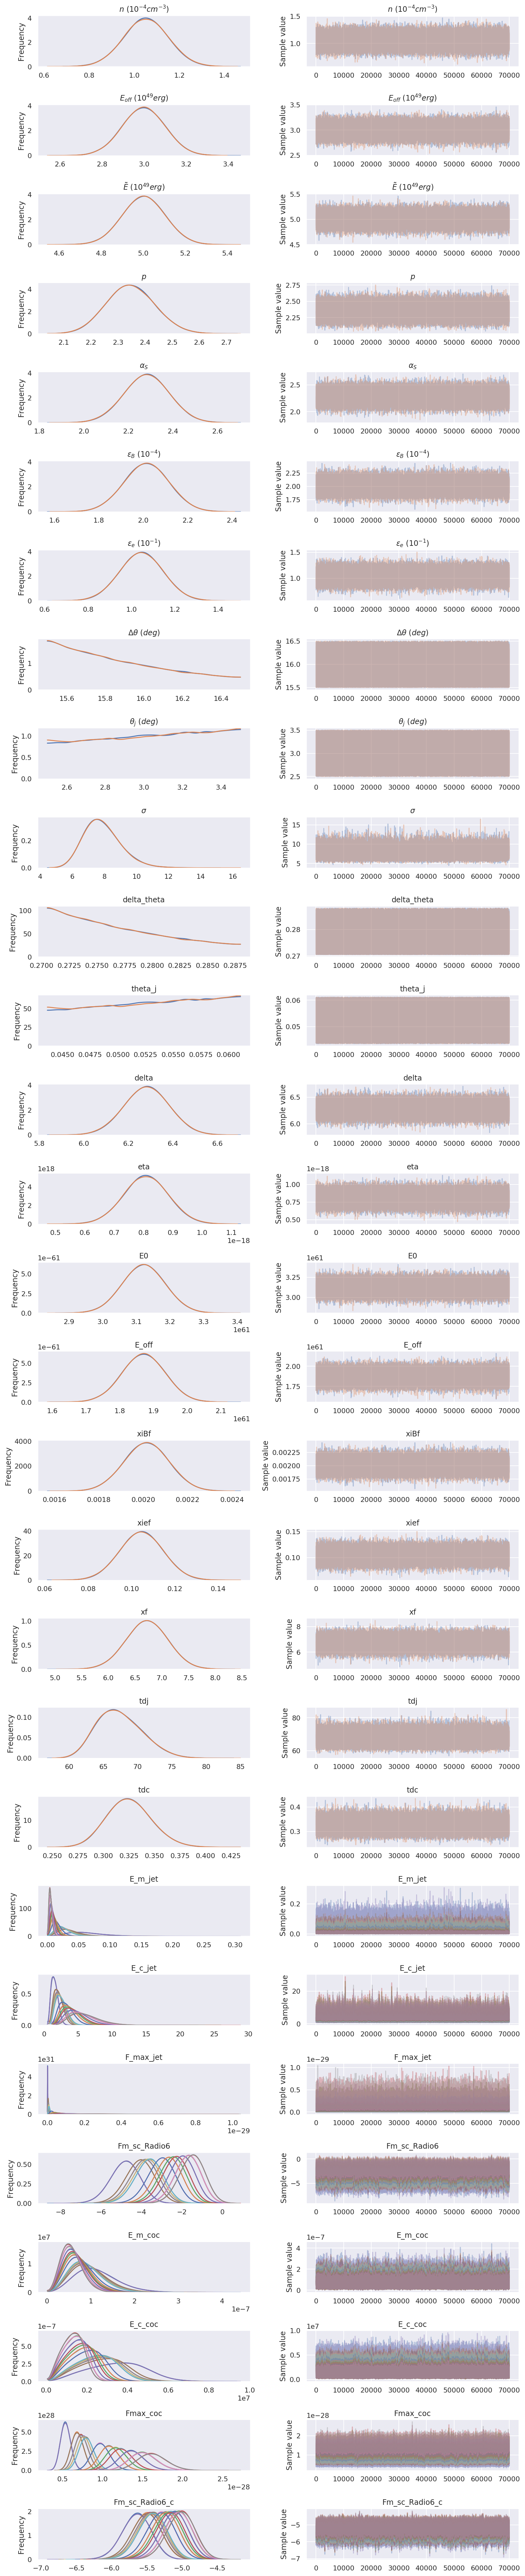

In [9]:
pm.traceplot(trace)

In [10]:
Radio6GHz_model.free_RVs

[$n \ (10^{-4}cm^{-3})$,
 $E_{off} \ (10^{49}erg)$,
 $\tilde{E} \ (10^{49}erg)$,
 $\Delta\theta \ (deg)$_interval__,
 $\theta_j \ (deg)$_interval__,
 $p$,
 $\alpha_S$,
 $\epsilon_B\ (10^{-4})$,
 $\epsilon_e \ (10^{-1}) $,
 $\sigma$_log__]

In [11]:
pm.summary(trace)

mean            sd      mc_error  \
$n \ (10^{-4}cm^{-3})$      1.052701e+00  9.762863e-02  2.236456e-04   
$E_{off} \ (10^{49}erg)$    2.998084e+00  1.003383e-01  2.008269e-04   
$\tilde{E} \ (10^{49}erg)$  5.003251e+00  9.992192e-02  2.540332e-04   
$p$                         2.347407e+00  8.792198e-02  1.991962e-04   
$\alpha_S$                  2.282385e+00  9.996136e-02  2.325103e-04   
$\epsilon_B\ (10^{-4})$     2.015106e+00  9.952234e-02  2.601870e-04   
$\epsilon_e \ (10^{-1}) $   1.046474e+00  9.823909e-02  2.238634e-04   
$\Delta\theta \ (deg)$      1.588358e+01  2.749647e-01  6.286931e-04   
$\theta_j \ (deg)$          3.026674e+00  2.878501e-01  7.553335e-04   
$\sigma$                    7.887490e+00  1.138341e+00  3.092093e-03   
delta_theta                 2.772208e-01  4.799038e-03  1.097277e-05   
theta_j                     5.282543e-02  5.023932e-03  1.318306e-05   
delta                       6.282385e+00  9.996136e-02  2.325103e-04   
eta                         8.088430e-19  7.501299e-20  1.718382e-22   
E0                          3.122784e+61  6.236637e+59  1.585551e+57   
E_off                       1.871257e+61  6.262622e+59  1.253463e+57   
xiBf                        2.015106e-03  9.952234e-05  2.601870e-07   
xief                        1.046474e-01  9.823909e-03  2.238634e-05   
xf                          6.722329e+00  3.828900e-01  9.405159e-04   
tdj                         6.740300e+01  3.261548e+00  7.280184e-03   
tdc                         3.255186e-01  2.161665e-02  5.132249e-05   
E_m_jet__0                  6.234019e-02  3.015851e-02  7.212865e-05   
E_m_jet__1                  3.601913e-02  1.742509e-02  4.167474e-05   
E_m_jet__2                  3.071007e-02  1.485671e-02  3.553207e-05   
E_m_jet__3                  3.072766e-02  1.486522e-02  3.555242e-05   
E_m_jet__4                  2.774328e-02  1.342146e-02  3.209945e-05   
E_m_jet__5                  2.548650e-02  1.232968e-02  2.948831e-05   
E_m_jet__6                  1.616121e-02  7.818359e-03  1.869879e-05   
E_m_jet__7                  1.266682e-02  6.127868e-03  1.465573e-05   
E_m_jet__8                  1.074136e-02  5.196382e-03  1.242794e-05   
...                                  ...           ...           ...   
E_c_coc__12                 1.400339e+06  5.501099e+05  1.273677e+03   
E_c_coc__13                 1.311820e+06  5.156365e+05  1.194006e+03   
Fmax_coc__0                 5.416474e-29  6.226935e-30  1.508467e-32   
Fmax_coc__1                 6.893485e-29  7.835440e-30  1.895246e-32   
Fmax_coc__2                 7.394024e-29  8.376845e-30  2.025295e-32   
Fmax_coc__3                 7.392163e-29  8.374834e-30  2.024813e-32   
Fmax_coc__4                 7.731728e-29  8.741188e-30  2.112778e-32   
Fmax_coc__5                 8.025539e-29  9.057601e-30  2.188730e-32   
Fmax_coc__6                 9.804846e-29  1.096348e-29  2.645827e-32   
Fmax_coc__7                 1.091321e-28  1.214285e-29  2.928373e-32   
Fmax_coc__8                 1.173360e-28  1.301242e-29  3.136565e-32   
Fmax_coc__9                 1.236925e-28  1.368436e-29  3.297368e-32   
Fmax_coc__10                1.367513e-28  1.506025e-29  3.626447e-32   
Fmax_coc__11                1.507446e-28  1.652841e-29  3.977340e-32   
Fmax_coc__12                1.507350e-28  1.652740e-29  3.977101e-32   
Fmax_coc__13                1.621913e-28  1.772509e-29  4.263170e-32   
Fm_sc_Radio6_c__0          -5.646810e+00  2.019177e-01  5.279984e-04   
Fm_sc_Radio6_c__1          -5.509040e+00  1.995611e-01  5.195554e-04   
Fm_sc_Radio6_c__2          -5.468992e+00  1.989222e-01  5.171941e-04   
Fm_sc_Radio6_c__3          -5.469136e+00  1.989245e-01  5.172025e-04   
Fm_sc_Radio6_c__4          -5.443476e+00  1.985262e-01  5.157119e-04   
Fm_sc_Radio6_c__5          -5.422167e+00  1.982021e-01  5.144876e-04   
Fm_sc_Radio6_c__6          -5.307759e+00  1.965661e-01  5.081274e-04   
Fm_sc_Radio6_c__7          -5.246572e+00  1.957644e-01  5.048766e-04   
Fm_s

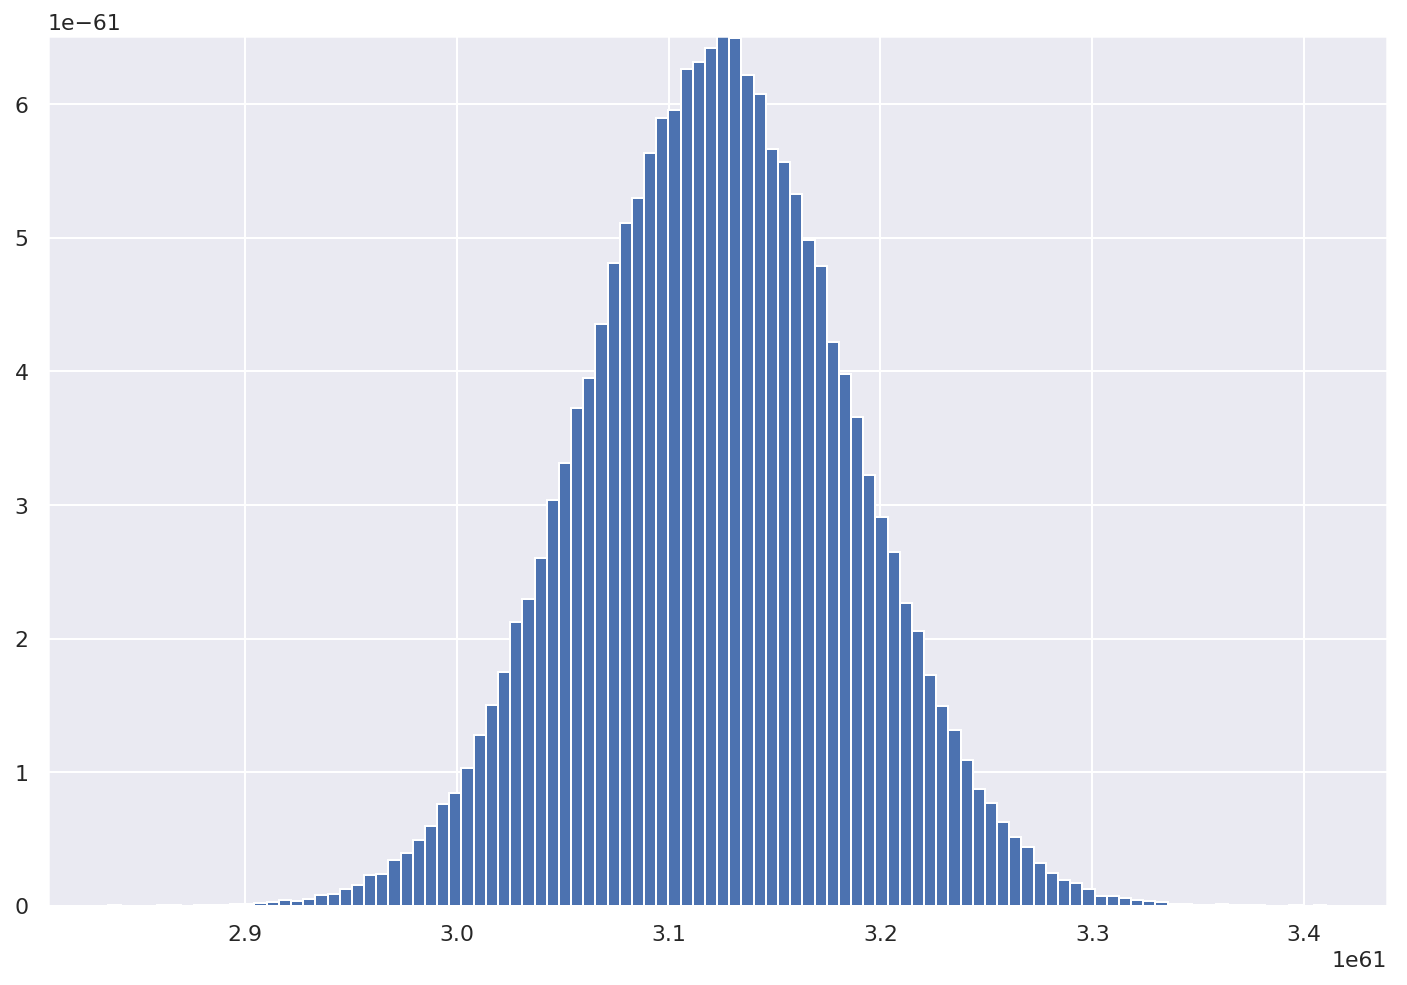

In [12]:
plt.hist(trace["E0"], bins=100, density=1.0)
plt.show()

In [13]:
import corner

In [14]:
E_j = r'$E_{off} \ (10^{49}erg)$'
E_c = r'$\tilde{E} \ (10^{49}erg)$'
n = r'$n \ (10^{-4}cm^{-3})$'
eb = r'$\epsilon_B\ (10^{-4})$'
ee = r'$\epsilon_e \ (10^{-1}) $'
theta = r'$\theta_j \ (deg)$'
dtheta = r'$\Delta\theta \ (deg)$'
p = r'$p$'
alpha =r'$\alpha_S$'
order = [E_j,E_c, n, p, theta, dtheta, eb, ee, alpha]
ndim = 9

In [15]:
radio6GHz = pd.read_csv("Output/Radio6GHz/output.csv",sep="\t")
radio6GHz = radio6GHz.drop(radio6GHz.columns[0], axis=1)
radio6GHz = radio6GHz.reindex(columns=order)

In [16]:
summary_radio6GHz = pd.read_csv("Output/Radio6GHz/summary.csv", sep="\t")
summary_radio6GHz = summary_radio6GHz.rename(index= {0:summary_radio6GHz.loc[0,'Unnamed: 0'],1:summary_radio6GHz.loc[1,'Unnamed: 0'],2:summary_radio6GHz.loc[2,'Unnamed: 0'],
    3:summary_radio6GHz.loc[3,'Unnamed: 0'],4:summary_radio6GHz.loc[4,'Unnamed: 0'],5:summary_radio6GHz.loc[5,'Unnamed: 0'],
    6:summary_radio6GHz.loc[6,'Unnamed: 0'],7:summary_radio6GHz.loc[7,'Unnamed: 0'],8:summary_radio6GHz.loc[8,'Unnamed: 0']})
summary_radio6GHz = summary_radio6GHz.drop(summary_radio6GHz.columns[0], axis=1)
summary_radio6GHz = summary_radio6GHz.reindex(index=order)

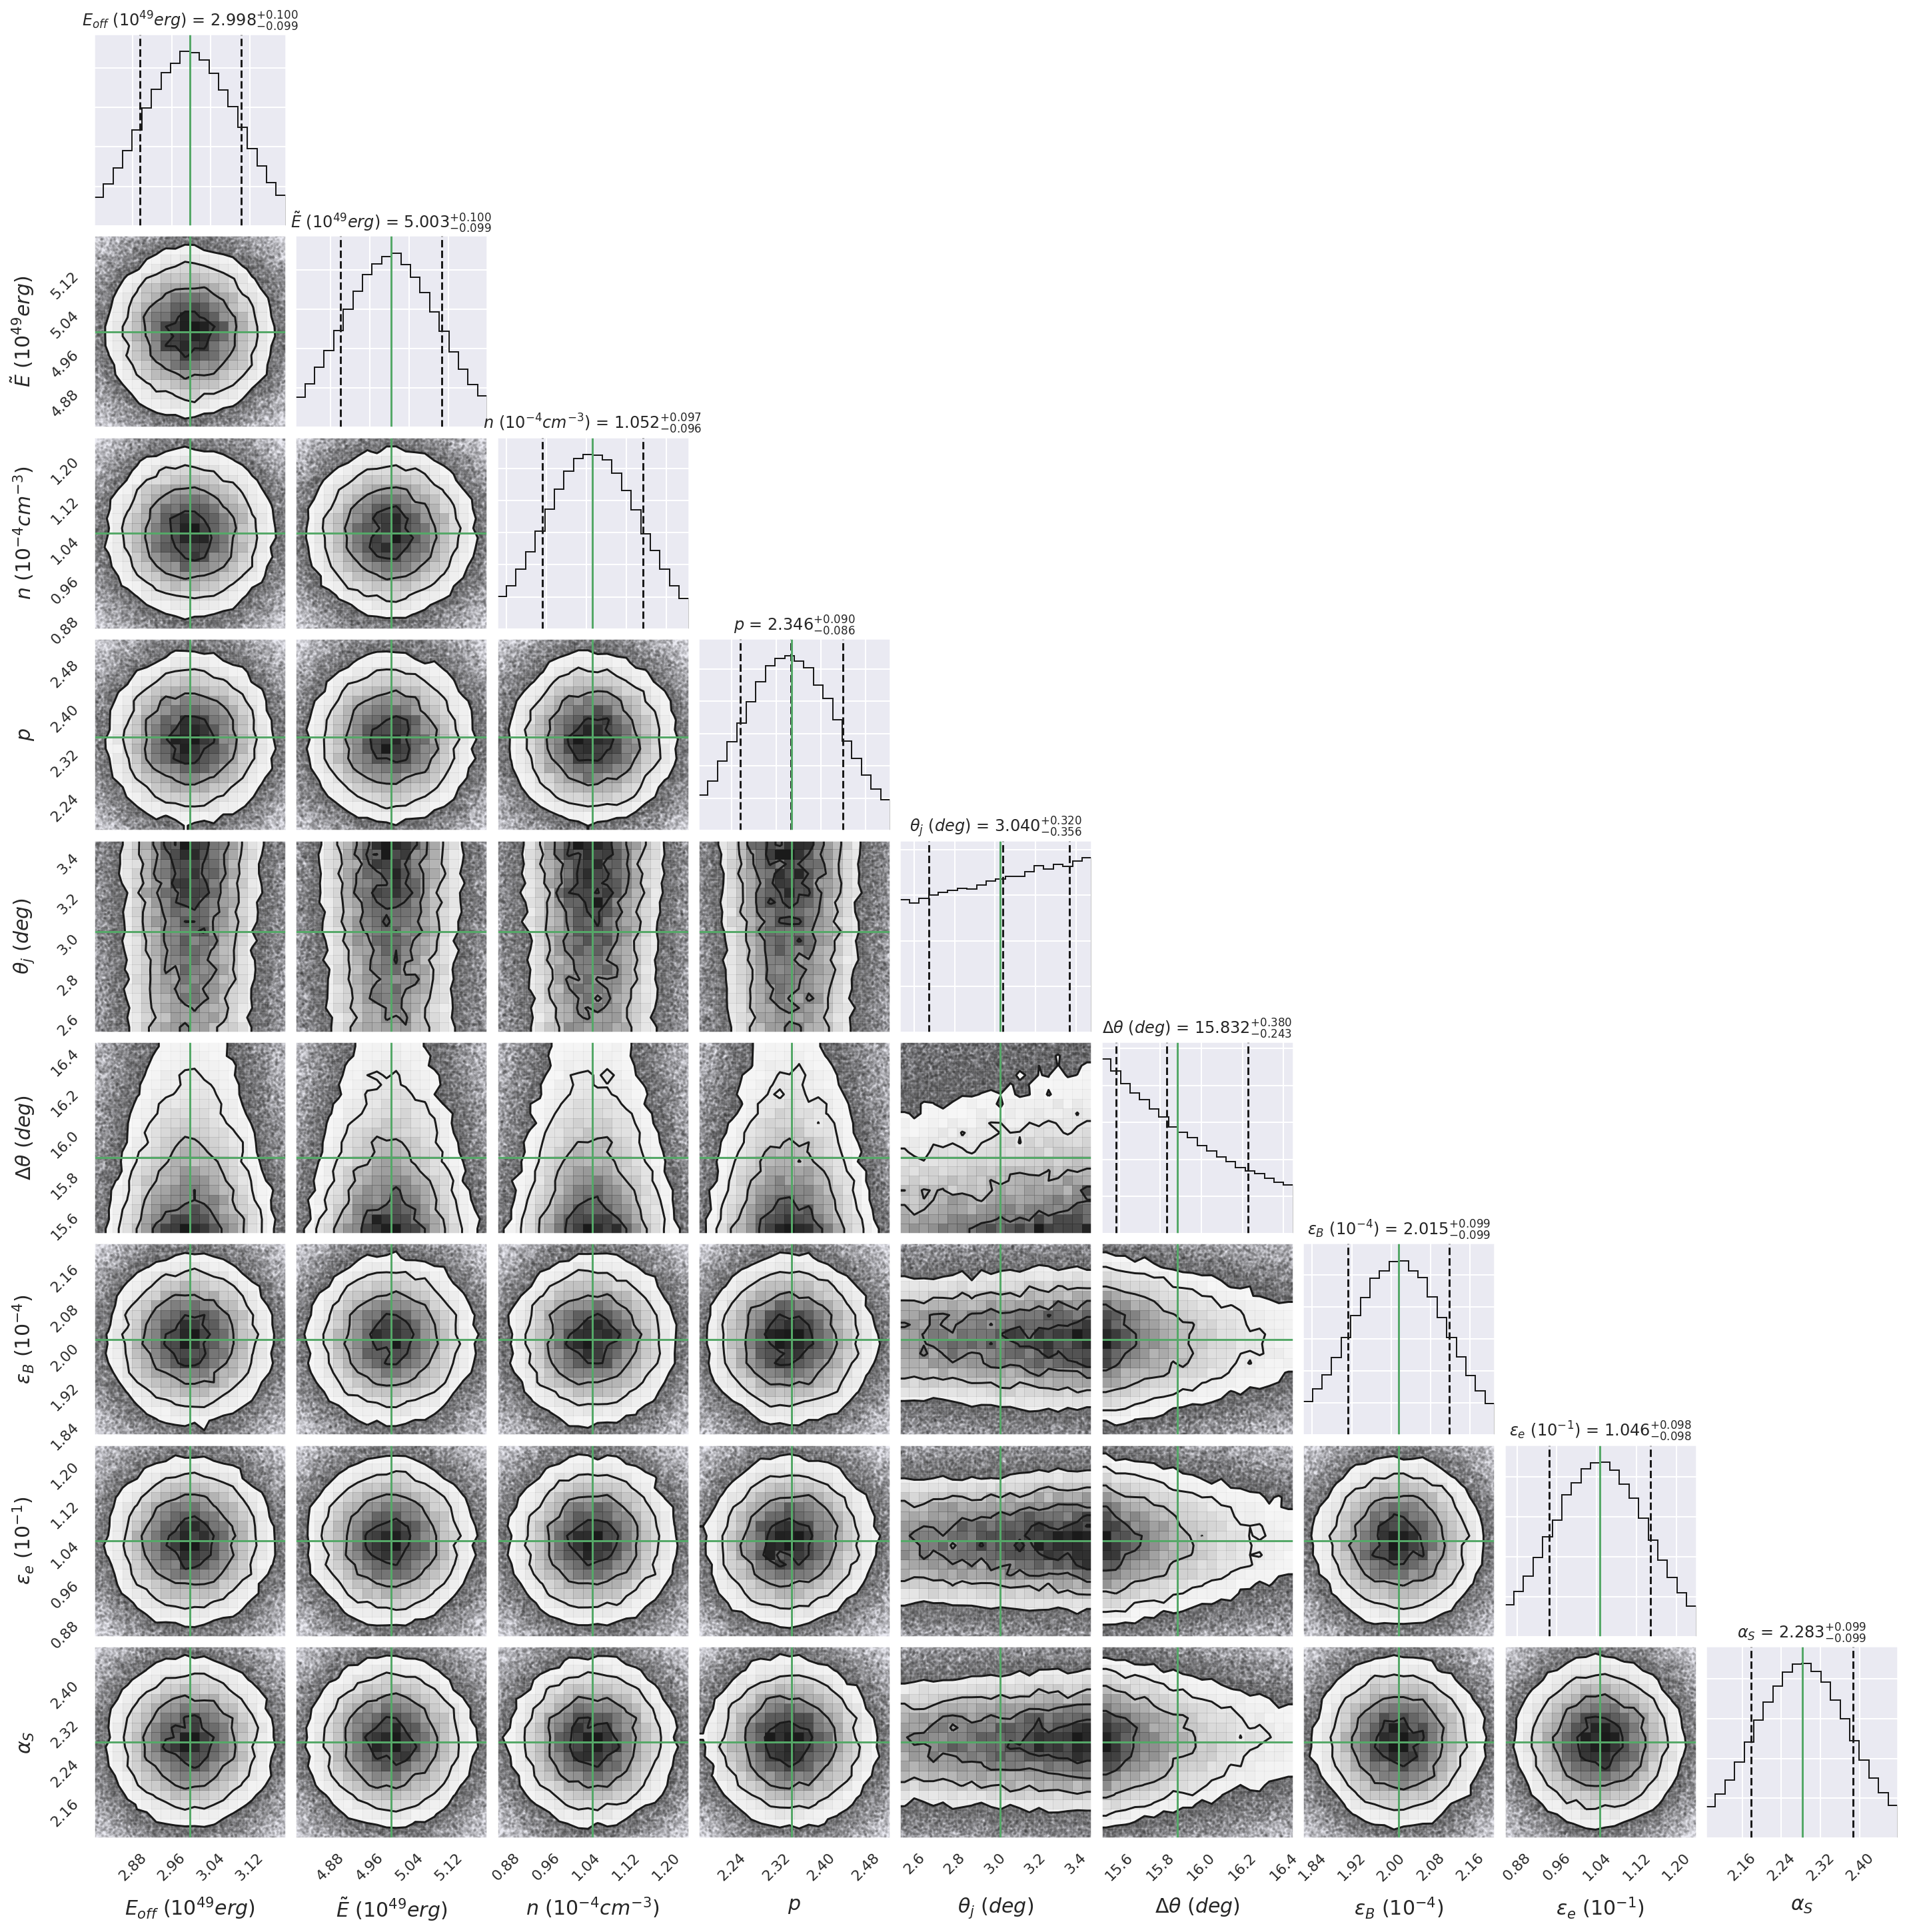

In [17]:
radio6ghz_cornerplot = corner.corner(radio6GHz, quantiles=[0.15, 0.50, 0.85],
    range=[0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95], label_kwargs={"fontsize": 15},
    show_titles=True,title_fmt='.3f', title_kwargs={"fontsize": 12})
#radio6ghz_cornerplot = corner.corner(radio6GHz,
#    label_kwargs={"fontsize": 15},
#    show_titles=True,title_fmt='.3f', title_kwargs={"fontsize": 12})

value1=summary_radio6GHz.loc[:,"mean"]

axes = np.array(radio6ghz_cornerplot.axes).reshape((ndim, ndim)) #Extract the axes
for i in range(ndim):     #Loop over the diagonal
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

for yi in range(ndim):    #Loop over the histograms
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")
plt.savefig("Output/Plots/Corner/Cornerplot_Radio6GHz.pdf")
plt.show()
plt.close()